[[771, 1628], [1132, 1620], [2801, 1594], [3014, 1589], [1621, 1955], [2952, 1863], [3917, 1789], array([3841.44670498, 5580.28468236]), array([8104.40707492, 2478.18354609]), array([-2143.37322942,  -546.5376902 ]), array([-10190.94773526,  -1922.29311756]), array([-54087.41130863,  -9426.51665212]), array([-157.80649692,  446.86797666]), array([-734.81021874,  387.21472889]), array([-6442.92764073,  -202.91620091]), array([-8075.86142948,  -371.73626256])]
[[39, 447], [92, 473], [656, 736], [838, 820], [566, 396], [831, 456], [1212, 546], array([868.25193667, 324.43034204]), array([1717.37387723,  449.15960268]), array([1199.40935702,  293.24883781]), array([1450.86796073,  319.78952739]), array([1777.72640621,  354.28844056]), array([1296.75283783,  260.53968055]), array([1365.70293273,  266.35580299]), array([1902.84255533,  311.66494748]), array([2020.35632364,  321.57754391])]


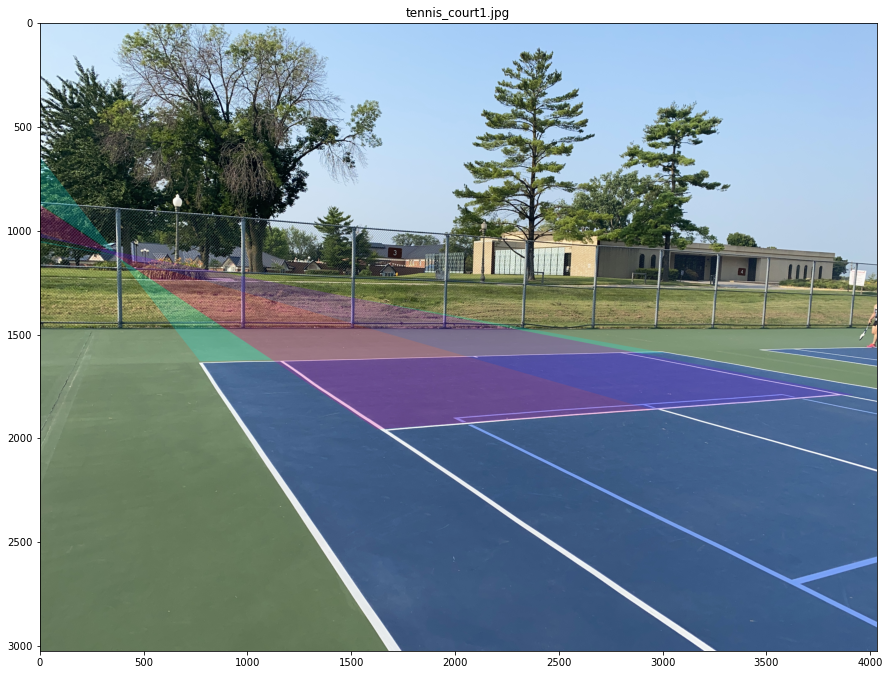

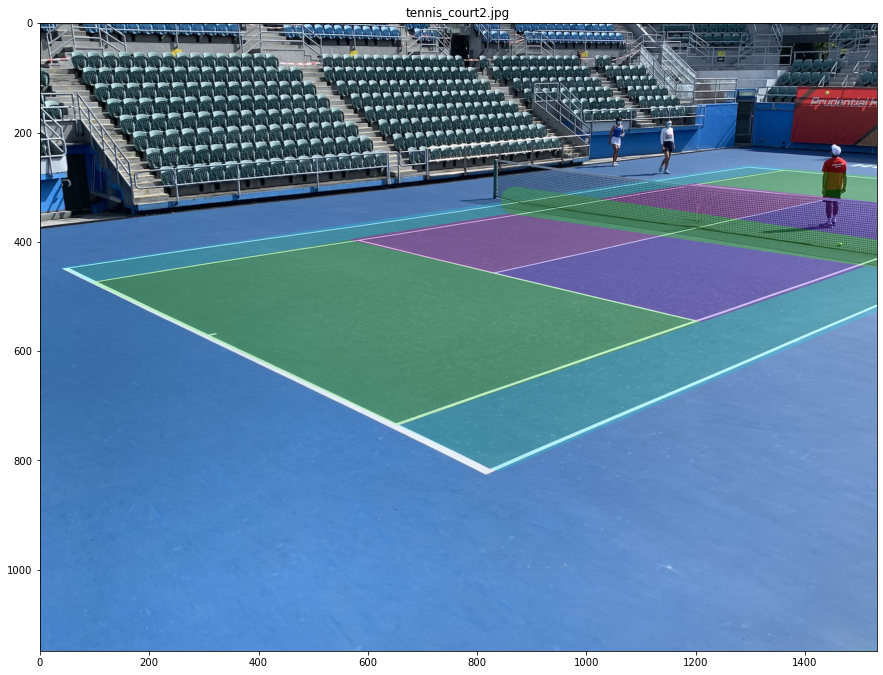

<Figure size 1080x1080 with 0 Axes>

In [263]:
import os
import cv2
import numpy as np
from matplotlib import pyplot as plt

#cycle over parameter tuning until 7 points found that fall in 3-point and 4-point lines
canny_threshold0 = 761
canny_threshold1 = 324
redundant_point_difference = 56

def check_if_court_feature(point, other_point, line):
    lx0 = line[0]
    ly0 = line[1]
    lx1 = line[2]
    ly1 = line[3]
    point_x = point[0]
    point_y = point[1]
    other_point_x = other_point[0]
    other_point_y = other_point[1]
    px = lx1 - lx0
    two_point_x_diff = point_x - other_point_x
    
    if px != 0 and two_point_x_diff != 0:
        py = ly1 - ly0
        m0 = py/px
        m1 = (point_y - other_point_y)/two_point_x_diff
        angle = np.arctan((m1 - m0)/(1 + m0*m1))
        
        if abs(angle) > .1:
            norm = px*px + py*py
            u =  ((point_x - lx0) * px + (point_y - ly0) * py) / float(norm)

            if u > 1:
                u = 1
            elif u < 0:
                u = 0

            x = lx0 + u * px
            y = ly0 + u * py
            dx = x - point_x
            dy = y - point_y

            if (dx*dx + dy*dy)**.5 < 2:
                add_point = True
                
                for court_point in court_points:
                    if ((point_x - court_point["point_x"])**2 + (point_y - court_point["point_y"])**2)**.5 < redundant_point_difference:
                        add_point = False
                
                if add_point:
                    court_points.append({"point_x": point_x, "point_y": point_y, "m0": m0, "m1": m1, "b0": point_y - point_x*m0, "b1": point_y - point_x*m1})
                    
def process_image(image):
    global line_img
    global court_points
    rgb_img = cv2.cvtColor(cv2.imread(directory+'/'+image), cv2.COLOR_BGR2RGB)
    width = rgb_img.shape[0]
    dilation_level = round(width/200)
    min_line_distance = round(width/3)
    max_line_gap = round(width/200)
    hough_threshold = round(width/2)
    line_img = rgb_img.copy()
    dilated = cv2.dilate(cv2.Canny(cv2.cvtColor(rgb_img, cv2.COLOR_RGB2GRAY), canny_threshold0, canny_threshold1, apertureSize = 3), np.ones((dilation_level, dilation_level)))
    linesP = cv2.HoughLinesP(dilated, 1, np.pi/180, hough_threshold, None, min_line_distance, max_line_gap)
    number_of_lines = len(linesP)
    court_points = []
    
    for i in range(number_of_lines):
        s0 = linesP[i][0]
        s0end0 = (s0[0], s0[1])
        s0end1 = (s0[2], s0[3])
        
        for j in range(i+1, number_of_lines):
            s1 = linesP[j][0]
            s1end0 = (s1[0], s1[1])
            s1end1 = (s1[2], s1[3])
            check_if_court_feature(s0end0, s0end1, s1)
            check_if_court_feature(s0end1, s0end0, s1)
            check_if_court_feature(s1end0, s1end1, s0)
            check_if_court_feature(s1end1, s1end0, s0)
            
    number_of_court_points = len(court_points)
    
    if number_of_court_points == 7:
        starting_idx = 0
        three_and_four_set_found = False
        
        while starting_idx < 7 and not three_and_four_set_found:
            slope0_idxs = [starting_idx]
            slope1_idxs = [starting_idx]

            for comparitor_idx in range(7):
                if starting_idx != comparitor_idx:
                    if abs(court_points[starting_idx]["m0"]*court_points[comparitor_idx]["point_x"] + court_points[starting_idx]["b0"] - court_points[comparitor_idx]["point_y"]) < 10:
                        slope0_idxs.append(comparitor_idx)
                        
                    if abs(court_points[starting_idx]["m1"]*court_points[comparitor_idx]["point_x"] + court_points[starting_idx]["b1"] - court_points[comparitor_idx]["point_y"]) < 10:
                        slope1_idxs.append(comparitor_idx)
            set0 = []
            set1 = []
            
            if len(slope0_idxs) == 4:
                three_and_four_set_found = True
                
                for i in range(7):
                    if i in slope0_idxs:
                        set0.append(court_points[i])
                    else:
                        set1.append(court_points[i])        
            elif len(slope1_idxs) == 4:
                three_and_four_set_found = True
                
                for i in range(7):
                    if i in slope1_idxs:
                        set0.append(court_points[i])
                    else:
                        set1.append(court_points[i])
            else:          
                starting_idx += 1
                
            if three_and_four_set_found:
                set0 = sorted(set0, key=lambda d: d['point_x'])
                set1 = sorted(set1, key=lambda d: d['point_x'])
                slanted_set = set0 + set1
                rectangle = [1, 2, 6, 4]
                pts = []
                ptss = [[sp["point_x"], sp["point_y"]] for sp in slanted_set]
                
                for idx in rectangle:
                    sp = slanted_set[idx]
                    pts.append([sp["point_x"], sp["point_y"]])
                    
                m = line_img.copy()
                alpha = .8
                dst = np.array(ptss)
                    
                src = np.array([[0, 0], [1372, 0], [9601, 0], [10973, 0],
                        [1372, 5486], [5486, 5486], [9601, 5486]])
                
                h, _ = cv2.findHomography(src, dst)
                
                src2 = np.array([[[0, 0]], [[1372, 0]], [[9601, 0]], [[10973, 0]],
                        [[1372, 5486]], [[5486, 5486]], [[9601, 5486]]], dtype = float)
    
                new_yo = cv2.perspectiveTransform(src2, h)
        
                others = np.array([[[0, 11887]], [[10973, 11887]],
                    [[1372, 18288]], [[5486, 18288]], [[9601, 18288]],
                    [[0, 23774]], [[1372, 23774]], [[9601, 23774]], [[10973, 23774]]], dtype=float)
                
                others2 = cv2.perspectiveTransform(others, h)
                combined = ptss + [sp[0] for sp in others2]
                print(combined)
                back_rectangle_indices = [[1, 2, 6, 4], [9, 11, 14, 12]]
                lane_indices = [[0, 1, 13, 12], [2, 3, 15, 14]]
                left_center_indices = [4, 5, 10, 9]
                right_center_indices = [5, 6, 11, 10]
                back_rectangles = []
                lanes = []
                left_center = []
                right_center = []
                
                for br in back_rectangle_indices:
                    brc = []
                    
                    for bri in br:
                        brc.append(combined[bri])
                        
                    back_rectangles.append(np.array(brc, dtype=int))
                    
                for l in lane_indices:
                    lc = []
                    
                    for li in l:
                        lc.append(combined[li])
                        
                    lanes.append(np.array(lc, dtype=int))
                    
                for lci in left_center_indices:
                        left_center.append(combined[lci])
                        
                for rci in right_center_indices:
                        right_center.append(combined[rci])
                
                cv2.fillPoly(m, back_rectangles, (55, 255, 0))
                cv2.fillPoly(m, lanes, (0, 255, 251))
                cv2.fillPoly(m, [np.array(left_center, dtype=int)], (255, 0, 170))
                cv2.fillPoly(m, [np.array(right_center, dtype=int)], (128, 0, 255))
                cv2.line(m,(int(combined[7][0]),int(combined[7][1])),(int(combined[8][0]),int(combined[8][1])),(55, 255, 0),50)
                line_img = cv2.addWeighted(line_img, alpha, m, 1-alpha, 0.0)
                plt.title(image)
                plt.imshow(line_img)
                plt.figure()
    
directory = 'tennis_court_images'
plt.rcParams["figure.figsize"] = 15, 15
    
for image in os.listdir('tennis_court_images'):
    process_image(image)
